In [89]:
import pandas as pd
import numpy as np  # Import numpy for calculations related to figure size
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import six

import seaborn as sns



In [64]:
# Read the data
file_path = '../Data File Repository/Combined_Rental_Median_Price_Inventory.csv'
df = pd.read_csv(file_path)

In [65]:
# Clean and preprocess data (remove dollar signs and convert to float)
df.replace({'\$':'', ',':''}, regex=True, inplace=True)
for col in df.columns[1:]:  # Starting from 1 to skip 'Borough'
    if 'Rent' in col:  # Only columns with 'Rent' in their name are monetary values
        df[col] = df[col].astype(float)


In [66]:
# Split data into pre-COVID and post-COVID (assuming pre-COVID is before 2020)
pre_covid_years = [str(year) for year in range(2010, 2020)]
post_covid_years = [str(year) for year in range(2020, 2024)]


In [67]:
# Create a function to calculate the summary statistics
def calculate_statistics(df, years):
    summary_stats = pd.DataFrame()
    for year in years:
        rentals_col = f'{year} Total Rentals'
        median_rent_col = f'{year} Median Rent'
        summary_stats[f'{year} Avg Total Rentals'] = [df[rentals_col].mean()]
        summary_stats[f'{year} Avg Median Rent'] = [df[median_rent_col].mean()]
    summary_stats['Period'] = 'Pre-COVID' if '2010' in years else 'Post-COVID'
    return summary_stats


In [68]:
# Calculate summary statistics for pre-COVID and post-COVID periods
pre_covid_stats = calculate_statistics(df, pre_covid_years)
post_covid_stats = calculate_statistics(df, post_covid_years)


In [69]:
# Merge both summary statistics
summary_comparison = pd.concat([pre_covid_stats, post_covid_stats], ignore_index=True)


In [70]:
# Calculate changes from pre-COVID to post-COVID for each Borough
change_stats_list = []  # Use a list to store data temporarily

for borough in df['Borough'].unique():  # Make sure to use unique to avoid repetitive calculations
    borough_data = df[df['Borough'] == borough]
    pre_avg_rentals = borough_data[[year + ' Total Rentals' for year in pre_covid_years]].mean(axis=1).values[0]
    post_avg_rentals = borough_data[[year + ' Total Rentals' for year in post_covid_years]].mean(axis=1).values[0]
    pre_avg_rent = borough_data[[year + ' Median Rent' for year in pre_covid_years]].mean(axis=1).values[0]
    post_avg_rent = borough_data[[year + ' Median Rent' for year in post_covid_years]].mean(axis=1).values[0]
    
    # Append borough data to the list as a dictionary
    change_stats_list.append({
        'Borough': borough,
        'Change in Avg Rentals': post_avg_rentals - pre_avg_rentals,
        'Change in Avg Median Rent': post_avg_rent - pre_avg_rent,
        'Percentage Change in Rentals': ((post_avg_rentals - pre_avg_rentals) / pre_avg_rentals) * 100 if pre_avg_rentals else None,
        'Percentage Change in Median Rent': ((post_avg_rent - pre_avg_rent) / pre_avg_rent) * 100 if pre_avg_rent else None,
    })


In [71]:
# Convert the list of dictionaries to a DataFrame
change_stats = pd.DataFrame(change_stats_list)


In [72]:
# Format 'Change in Avg Rentals' to whole numbers
change_stats['Change in Avg Rentals'] = change_stats['Change in Avg Rentals'].astype(int)

# Format 'Change in Avg Median Rent' as currency
change_stats['Change in Avg Median Rent'] = change_stats['Change in Avg Median Rent'].apply(lambda x: "${:,.2f}".format(x))

# Format percentages to one decimal place with % symbols
change_stats['Percentage Change in Rentals'] = change_stats['Percentage Change in Rentals'].apply(lambda x: "{:.1f}%".format(x) if pd.notnull(x) else None)
change_stats['Percentage Change in Median Rent'] = change_stats['Percentage Change in Median Rent'].apply(lambda x: "{:.1f}%".format(x) if pd.notnull(x) else None)


In [73]:
# Display the title with Markdown
display(Markdown('### Change in Rentals and Median Rent by Borough (Pre vs. Post COVID-19)'))

# Display the change stats DataFrame
change_stats

### Change in Rentals and Median Rent by Borough (Pre vs. Post COVID-19)

,Borough,Change in Avg Rentals,Change in Avg Median Rent,Percentage Change in Rentals,Percentage Change in Median Rent
0,Bronx,6937,$474.92,53.4%,31.8%
1,Brooklyn,166927,$496.53,55.8%,22.8%
2,Manhattan,69812,$502.03,11.0%,15.3%
3,Queens,72425,$382.59,71.0%,21.0%
4,Staten Island,104,$608.85,17.7%,43.4%


In [74]:
# Function to render a dataframe as a table using matplotlib
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors) ])
    return ax

In [75]:
# Create a larger figure if needed
plt.figure(figsize=(25, 8))  

# Render your table to the figure
ax = render_mpl_table(change_stats, header_columns=1, col_width=4.0)  
fig = ax.get_figure()

# Set the title
fig.suptitle('Change in Rentals and Median Rent by Borough (Pre vs. Post COVID-19)', size=16)

# Adjust the layout
fig.tight_layout()

# Adjust the layout to accommodate the title
fig.subplots_adjust(top=0.9)  

# Save the figure
plt.savefig('../Charts and Graphs Output/change_stats_table.png', dpi=300, bbox_inches='tight')
plt.close(fig) 

<Figure size 2500x800 with 0 Axes>

In [76]:
# Set the visualisation style
sns.set_style("whitegrid")


In [77]:
# Check data types
print(change_stats.dtypes)


Borough                             object
Change in Avg Rentals                int64
Change in Avg Median Rent           object
Percentage Change in Rentals        object
Percentage Change in Median Rent    object
dtype: object


In [78]:
# Remove any non-numeric characters (like $, commas, etc.) and convert to float
change_stats['Change in Avg Median Rent'] = (
    change_stats['Change in Avg Median Rent']
    .replace('[\$,]', '', regex=True)
    .astype(float)
)

change_stats['Percentage Change in Rentals'] = (
    change_stats['Percentage Change in Rentals']
    .replace('[\%,]', '', regex=True)
    .astype(float)
)

change_stats['Percentage Change in Median Rent'] = (
    change_stats['Percentage Change in Median Rent']
    .replace('[\%,]', '', regex=True)
    .astype(float)
)

In [79]:
# Verify the changes
print(change_stats.dtypes)

Borough                              object
Change in Avg Rentals                 int64
Change in Avg Median Rent           float64
Percentage Change in Rentals        float64
Percentage Change in Median Rent    float64
dtype: object


In [80]:
# If necessary, convert 'Borough' to category (if not already)
change_stats['Borough'] = change_stats['Borough'].astype('category')


In [81]:
# Instead of formatting 'Change in Avg Median Rent', 'Percentage Change in Rentals', and 'Percentage Change in Median Rent' as currency and percentage strings, convert to appropriate numeric types first
change_stats['Change in Avg Median Rent'] = change_stats['Change in Avg Median Rent'].astype(float)
change_stats['Percentage Change in Rentals'] = change_stats['Percentage Change in Rentals'].replace('[\%,]', '', regex=True).astype(float)
change_stats['Percentage Change in Median Rent'] = change_stats['Percentage Change in Median Rent'].replace('[\%,]', '', regex=True).astype(float)


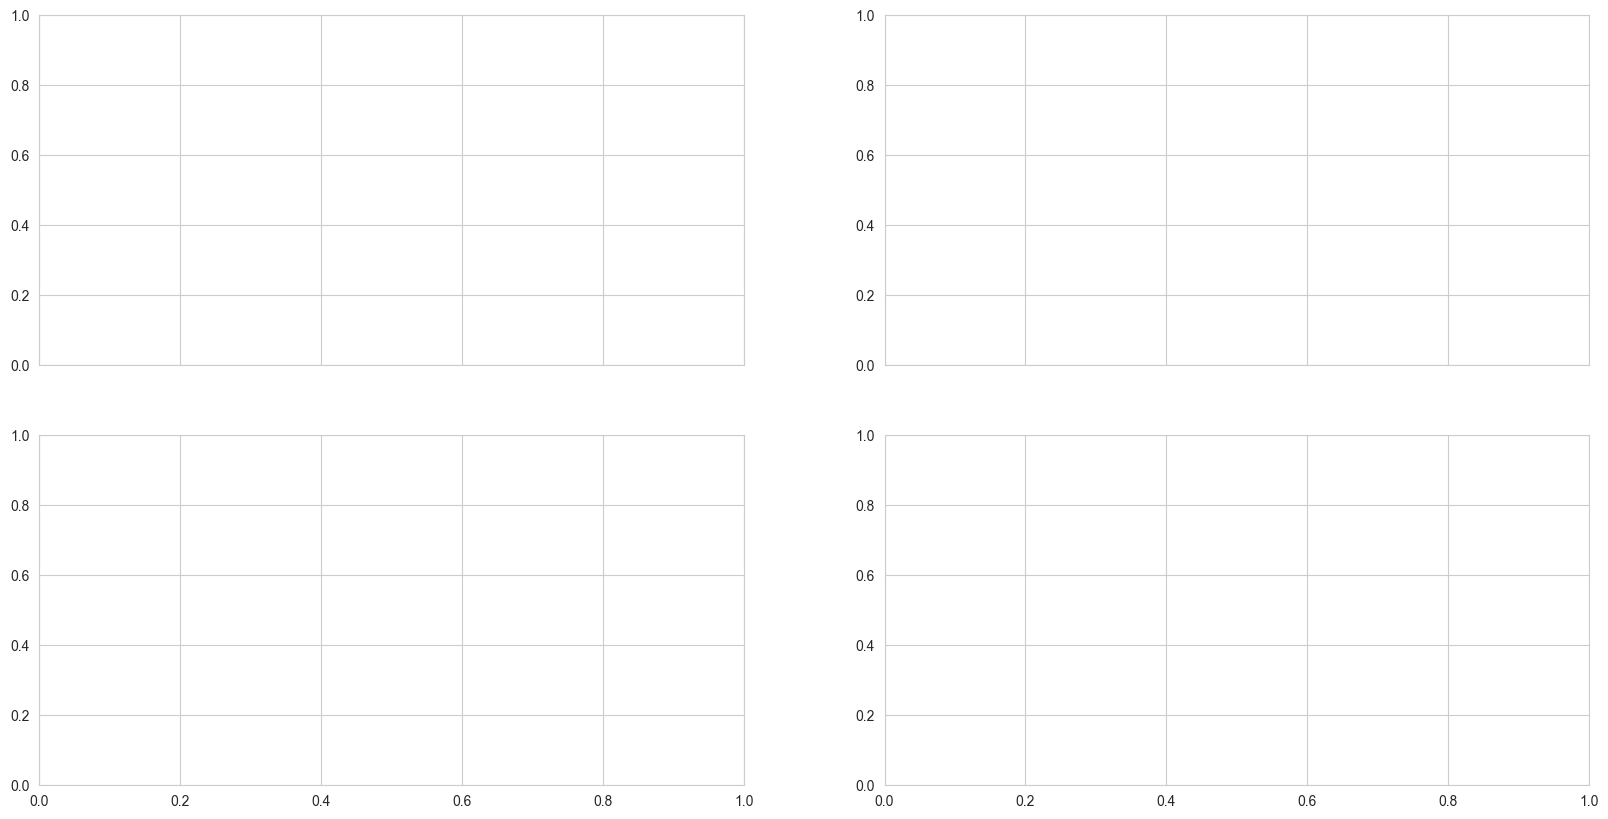

In [82]:
# Create subplots for each category
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True)


In [83]:
# Titles for the plots
titles = [
    'Change in Average Rentals',
    'Change in Average Median Rent',
    'Percentage Change in Rentals',
    'Percentage Change in Median Rent'
]


/Users/laurenpescarus/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/laurenpescarus/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/laurenpescarus/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/laurenpescarus/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641:

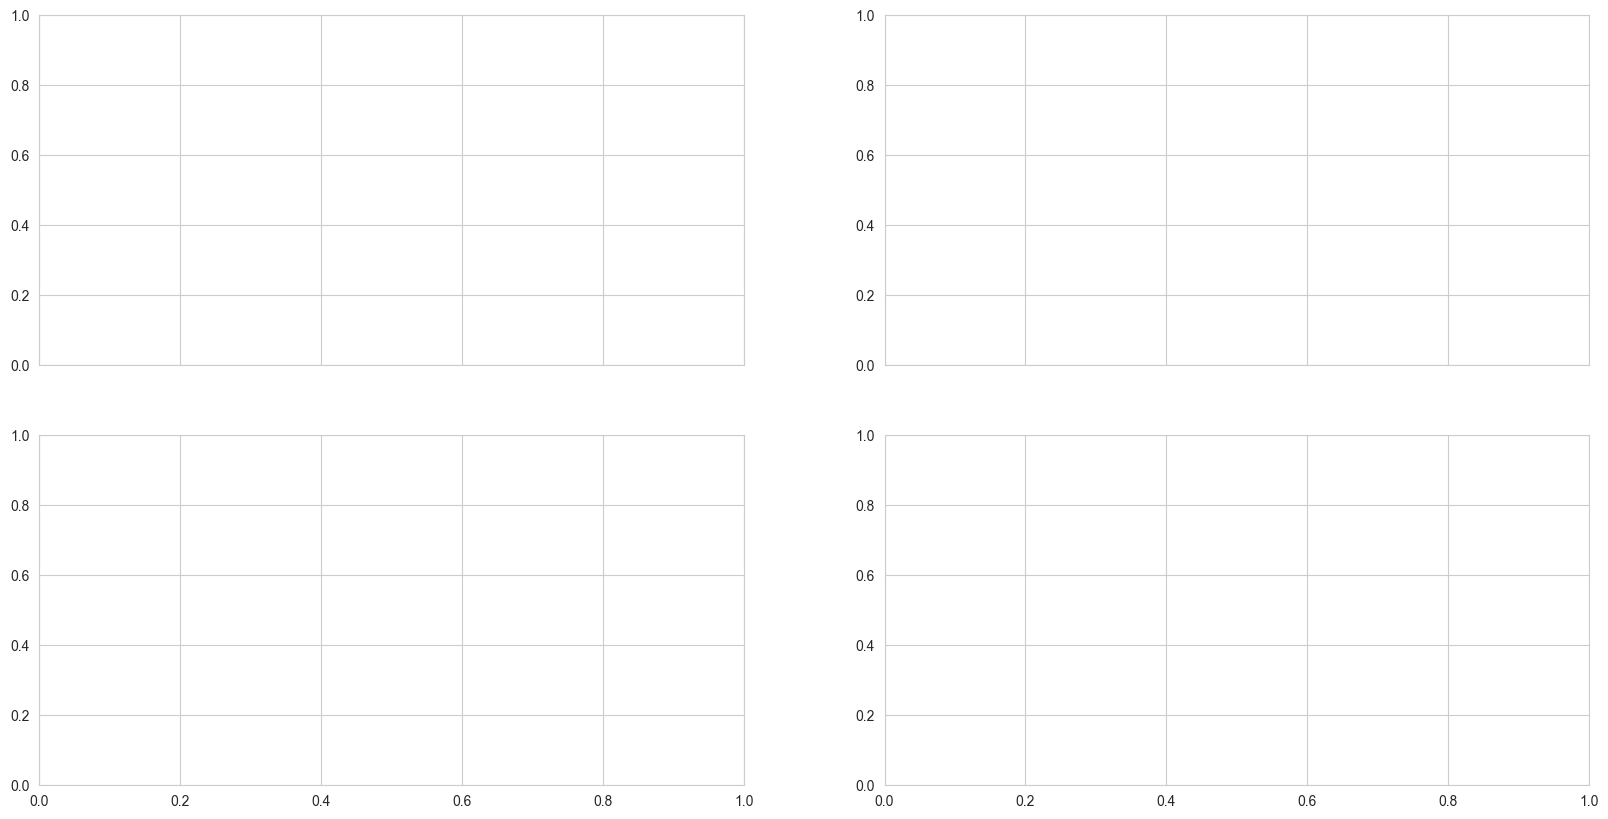

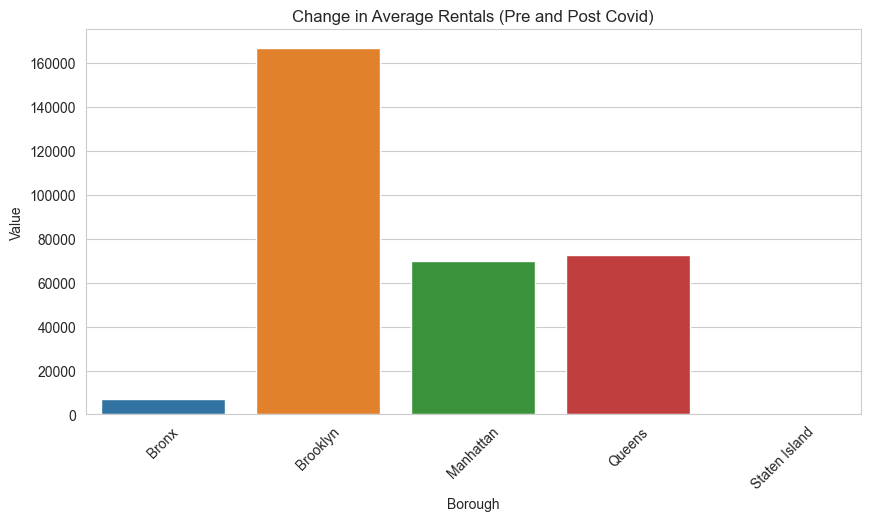

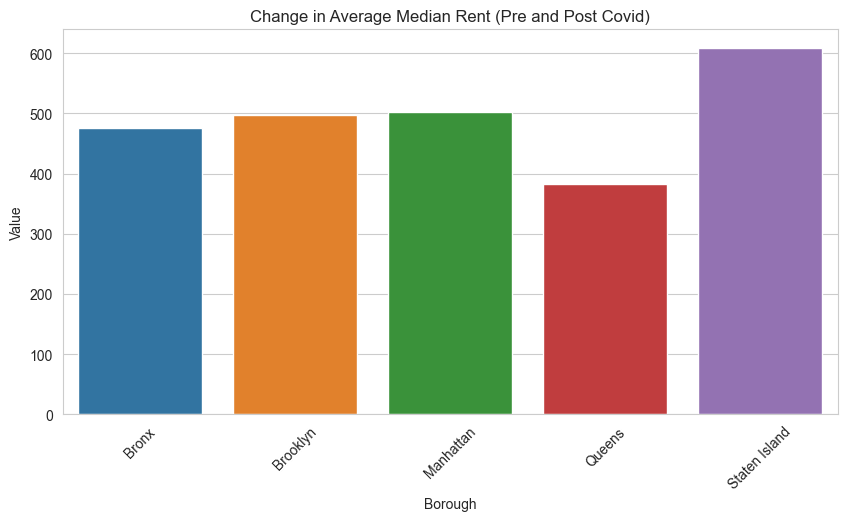

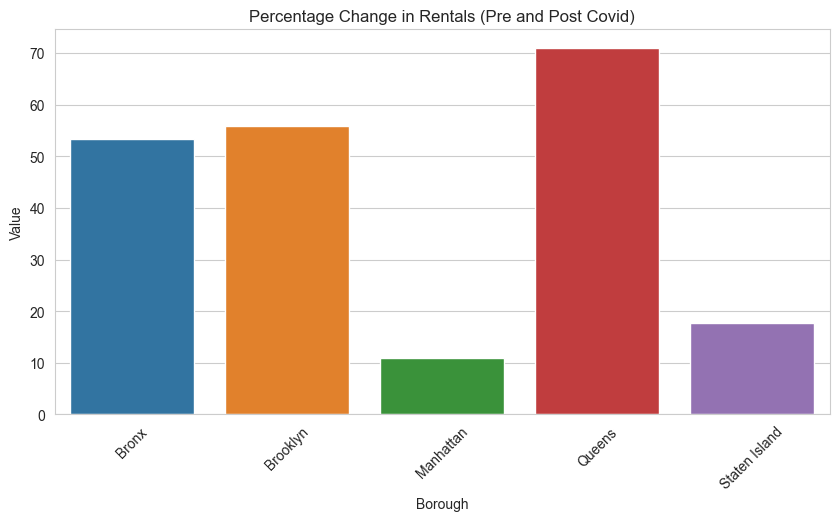

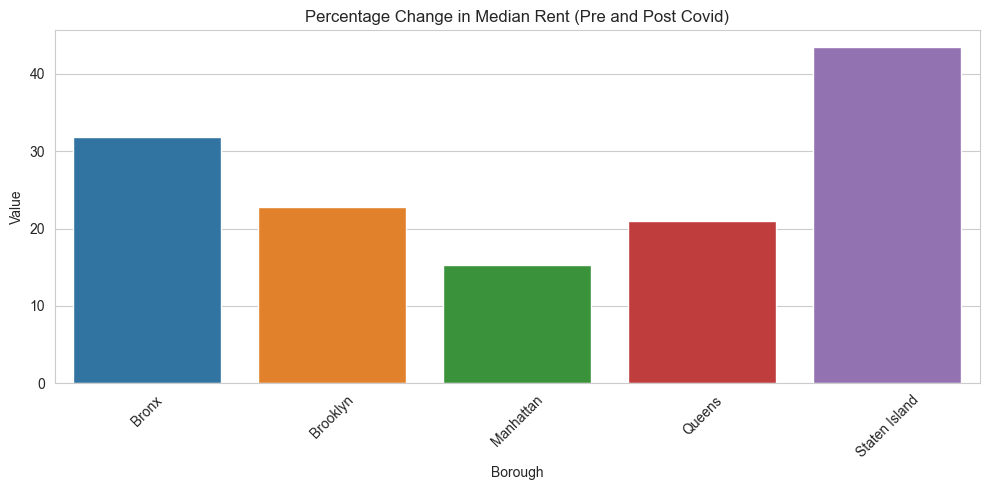

In [94]:
# Create subplots for each category
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True)

# Updated titles for the plots
titles = [
    'Change in Average Rentals (Pre and Post Covid)',
    'Change in Average Median Rent (Pre and Post Covid)',
    'Percentage Change in Rentals (Pre and Post Covid)',
    'Percentage Change in Median Rent (Pre and Post Covid)'
]

# Loop through the statistics and create bar plots
for i, col in enumerate(['Change in Avg Rentals', 'Change in Avg Median Rent', 
                         'Percentage Change in Rentals', 'Percentage Change in Median Rent']):
    # Ensure the data is numeric for plotting
    change_stats[col] = pd.to_numeric(change_stats[col].replace('[\$,%,]', '', regex=True))
    
    # Initialize a new figure for each plot
    plt.figure(figsize=(10, 5))
    
    # Plot using seaborn
    ax = sns.barplot(x='Borough', y=col, data=change_stats)
    
    # Set title with the updated titles including "Pre and Post Covid"
    ax.set_title(titles[i])
    ax.set_ylabel('Value')
    
    # Rotate x-tick labels for better readability
    for item in ax.get_xticklabels():
        item.set_rotation(45)
    
    # Save the figure with a filename that reflects the title
    filename = f"{titles[i]}.png".replace(" ", "_").replace("(", "").replace(")", "").replace("&", "and")
    plt.savefig(f'../Charts and Graphs Output/{filename}', dpi=300, bbox_inches='tight')
    
# Adjust layout for better fit and to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()